# State Punishment Analysis Notebook
# ===================================

This notebook provides tools for analyzing TensorBoard results from state punishment experiments.
It includes data processing, visualization, and statistical analysis functions.

## Table of Contents
1. [Imports and Dependencies](#1-imports-and-dependencies)
2. [TensorBoard Data Processing](#2-tensorboard-data-processing)
3. [Data Analysis Utilities](#3-data-analysis-utilities)
4. [Visualization Functions](#4-visualization-functions)
5. [Statistical Analysis](#5-statistical-analysis)
6. [Data Processing Pipeline](#6-data-processing-pipeline)
7. [Example Analysis](#7-example-analysis)


## 1. Imports and Dependencies


In [4]:
# Core data processing and visualization
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
import time
from collections import defaultdict

# TensorFlow for TensorBoard processing
import tensorflow as tf
from tensorflow.python.framework.errors_impl import DataLossError

# Statistical analysis
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All imports successful!")


All imports successful!


## 2. TensorBoard Data Processing


In [5]:
def tensorboard_to_csv(event_file, csv_file):
    """
    Convert TensorBoard event file data to a CSV format.

    Args:
        event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
        csv_file (str): Path where the output CSV file should be saved.
    """
    data_rows = []
    
    # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            # Only consider scalar summaries
            if v.HasField('simple_value'):
                tag = v.tag
                value = v.simple_value
                step = e.step
                data_rows.append([step, tag, value])
    
    # Write the extracted data into a CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Step', 'Tag', 'Value'])
        writer.writerows(data_rows)
    
    print(f"Data from {event_file} has been written to {csv_file}")


In [6]:
def tensorboard_to_separate_csv(event_file, output_dir):
    """
    Convert TensorBoard event file to separate CSV files for each metric.
    
    Args:
        event_file (str): Path to the TensorBoard event file
        output_dir (str): Directory where CSV files should be saved
    """
    tag_data = defaultdict(list)

    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            try:
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        tag = v.tag
                        value = v.simple_value
                        step = e.step
                        tag_data[tag].append([step, value])
            except Exception as record_error:
                print(f"Skipped a corrupt record in file: {event_file}")
    except DataLossError:
        print(f"Encountered DataLossError. Possibly due to incomplete writes in file: {event_file}")

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")


In [7]:
def is_file_stable(file_path, wait_time=1.0):
    """Check if a file is stable (not being written to)."""
    initial_size = os.path.getsize(file_path)
    time.sleep(wait_time)
    final_size = os.path.getsize(file_path)
    return initial_size == final_size

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Process all TensorBoard files in a directory structure.
    
    Args:
        parent_dir (str): Parent directory containing TensorBoard event files
        output_parent_dir (str): Parent directory where CSV files should be saved
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:
                event_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                try:
                    tensorboard_to_separate_csv(event_file, output_dir)
                    print(f"Processed {event_file} -> {output_dir}")
                except Exception as e:
                    print(f"Failed to process {event_file}: {e}")


## 3. Data Analysis Utilities


In [8]:
def trim_and_calculate_mean(array_list):
    """
    Trim arrays to the same length and calculate mean.
    
    Args:
        array_list: List of arrays to process
        
    Returns:
        numpy.ndarray: Array of trimmed arrays
    """
    min_length = min(len(arr) for arr in array_list)
    trimmed_arrays = [arr[:min_length] for arr in array_list]
    return np.array(trimmed_arrays)

def exponential_moving_average(data, alpha):
    """
    Calculate the exponential moving average (EMA) of a 1D array.

    Args:
        data (array-like): The input data
        alpha (float): The smoothing factor (0 < alpha <= 1)

    Returns:
        numpy.ndarray: The EMA values
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

def rolling_average(data, window_size):
    """
    Calculate the rolling average of a 1D array.

    Args:
        data (array-like): The input data
        window_size (int): The size of the rolling window

    Returns:
        numpy.ndarray: The rolling average values
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be at least equal to the window size.")
    
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')


## 4. Visualization Functions


In [9]:
def plot_average_trajectory(time_series, error_type='std', time_points=None, 
                           xlabel='Time', ylabel='Value', title='Average Trajectory'):
    """
    Plot the average trajectory of a set of time series with error bars.

    Parameters:
    - time_series (2D array-like): A set of time series, shape (n_series, n_time_points)
    - error_type (str): Either 'std' for standard deviation or 'sem' for standard error
    - time_points (1D array-like, optional): Time points corresponding to the time series
    - xlabel (str): Label for the x-axis
    - ylabel (str): Label for the y-axis
    - title (str): Title of the plot
    """
    time_series = np.array(time_series)
    if time_points is None:
        time_points = np.arange(time_series.shape[1])
    else:
        time_points = np.array(time_points)
    
    if time_series.shape[1] != len(time_points):
        raise ValueError("Length of time_points must match the number of columns in time_series.")
    
    # Compute average and error
    mean_trajectory = np.mean(time_series, axis=0)
    if error_type == 'std':
        error = np.std(time_series, axis=0)
    elif error_type == 'sem':
        error = np.std(time_series, axis=0) / np.sqrt(time_series.shape[0])
    else:
        raise ValueError("error_type must be 'std' or 'sem'.")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, mean_trajectory, label='Mean Trajectory', color='blue')
    plt.fill_between(time_points, mean_trajectory - error, mean_trajectory + error, 
                     alpha=0.3, color='blue', label='Error')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_multiple_conditions(data_list, labels, window_size=200, title="Comparison"):
    """
    Plot multiple conditions with rolling average smoothing.
    
    Args:
        data_list: List of data arrays for each condition
        labels: List of labels for each condition
        window_size: Window size for rolling average
        title: Plot title
    """
    plt.figure(figsize=(12, 6))
    
    for i, (data, label) in enumerate(zip(data_list, labels)):
        if len(data) > window_size:
            smoothed = rolling_average(data, window_size)
            plt.plot(smoothed, label=label, alpha=0.8)
        else:
            plt.plot(data, label=label, alpha=0.8)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


## 5. Statistical Analysis


In [10]:
def coefficient_of_variation(timestamps):
    """
    Calculate the coefficient of variation (CV) of inter-visit intervals.
    
    Parameters:
    - timestamps: A list or array of timestamps representing the times of visits or events
    
    Returns:
    - CV: The coefficient of variation (standard deviation / mean) of inter-visit intervals
    """
    inter_visit_intervals = np.diff(timestamps)
    mean_interval = np.mean(inter_visit_intervals)
    std_dev_interval = np.std(inter_visit_intervals)
    cv = std_dev_interval / mean_interval
    return cv

def fourier_transform_periodicity(data):
    """
    Perform a Fourier Transform to find the dominant frequency and quantify periodicity.
    
    Parameters:
    - data: A list or array representing the time series data
    
    Returns:
    - dominant_period: The period corresponding to the dominant frequency
    - power_at_dominant_frequency: The strength of the dominant frequency
    """
    fft_result = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data))
    power = np.abs(fft_result)
    
    dominant_frequency = frequencies[np.argmax(power)]
    dominant_period = 1 / dominant_frequency
    
    return dominant_period, power[np.argmax(power)]

def correlation_analysis(x, y, method='spearman'):
    """
    Perform correlation analysis between two variables.
    
    Args:
        x, y: Arrays to correlate
        method: 'pearson' or 'spearman'
        
    Returns:
        correlation coefficient and p-value
    """
    if method == 'pearson':
        return pearsonr(x, y)
    elif method == 'spearman':
        return spearmanr(x, y)
    else:
        raise ValueError("Method must be 'pearson' or 'spearman'")

def multiple_regression_analysis(data_dict, target_var):
    """
    Perform multiple regression analysis.
    
    Args:
        data_dict: Dictionary with variable names as keys and arrays as values
        target_var: Name of the target variable
        
    Returns:
        Dictionary with regression results
    """
    df = pd.DataFrame(data_dict)
    
    # Separate features and target
    feature_vars = [col for col in df.columns if col != target_var]
    X = df[feature_vars]
    y = df[target_var]
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return {
        'intercept': model.intercept_,
        'coefficients': dict(zip(feature_vars, model.coef_)),
        'mse': mse,
        'r2': r2
    }


## 6. Data Processing Pipeline


In [11]:
def load_experiment_data(folders, entity_names, agent_filter=None):
    """
    Load and process data from multiple experiment folders.
    
    Args:
        folders: List of experiment folder names
        entity_names: List of entity/metric names to load
        agent_filter: Optional filter for specific agents (e.g., 'Agent_0')
        
    Returns:
        Dictionary with processed data for each folder and entity
    """
    results = {}
    
    for folder in folders:
        results[folder] = {}
        parent_dir = os.path.join('res', folder)
        
        if not os.path.exists(parent_dir):
            print(f"Warning: Directory {parent_dir} does not exist")
            continue
            
        files = os.listdir(parent_dir)
        
        for entity_name in entity_names:
            entity_data = []
            
            for f in files:
                if entity_name in f:
                    if agent_filter is None or agent_filter in f:
                        file_path = os.path.join(parent_dir, f)
                        try:
                            data = pd.read_csv(file_path)
                            entity_data.append(data['Value'].to_numpy())
                        except Exception as e:
                            print(f"Error reading {file_path}: {e}")
            
            if entity_data:
                # Calculate mean across runs
                processed_data = np.mean(trim_and_calculate_mean(entity_data), axis=0)
                results[folder][entity_name] = processed_data
            else:
                print(f"No data found for {entity_name} in {folder}")
    
    return results

def compare_conditions(data_dict, metric_name, labels=None, window_size=200):
    """
    Compare a specific metric across different conditions.
    
    Args:
        data_dict: Dictionary with experiment data
        metric_name: Name of the metric to compare
        labels: Optional labels for conditions
        window_size: Window size for smoothing
    """
    data_list = []
    condition_labels = []
    
    for folder, metrics in data_dict.items():
        if metric_name in metrics:
            data_list.append(metrics[metric_name])
            condition_labels.append(folder if labels is None else labels[len(data_list)-1])
    
    if data_list:
        plot_multiple_conditions(data_list, condition_labels, window_size, f"{metric_name} Comparison")
    else:
        print(f"No data found for metric: {metric_name}")


## 7. Example Analysis


In [ ]:
# Example: Process TensorBoard results
# Uncomment and modify paths as needed

parent_dir = '../runs_p48'
output_dir = 'res'
process_tensorboard_results(parent_dir, output_dir)


In [ ]:
# Example: Load and analyze experiment data

# Define experiment folders
example_folders = [
    'experiment_1',
    'experiment_2', 
    'experiment_3'
]

# Define metrics to analyze
metrics = ['Reward', 'Loss', 'Epsilon']

# Load data
# experiment_data = load_experiment_data(example_folders, metrics)

# Compare rewards across conditions
# compare_conditions(experiment_data, 'Reward', 
#                   labels=['Condition 1', 'Condition 2', 'Condition 3'])

print("Example analysis functions ready. Uncomment and modify as needed.")


In [ ]:
# Example: Statistical analysis

# Generate example data for demonstration
np.random.seed(42)
x = np.random.randn(1000)
y = 2 * x + np.random.randn(1000) * 0.5

# Correlation analysis
corr_coef, p_value = correlation_analysis(x, y, method='pearson')
print(f"Pearson correlation: {corr_coef:.3f}, p-value: {p_value:.3e}")

# Multiple regression example
example_data = {
    'X1': x,
    'X2': np.random.randn(1000),
    'Y': y
}

regression_results = multiple_regression_analysis(example_data, 'Y')
print(f"\nRegression Results:")
print(f"R²: {regression_results['r2']:.3f}")
print(f"MSE: {regression_results['mse']:.3f}")
print(f"Coefficients: {regression_results['coefficients']}")


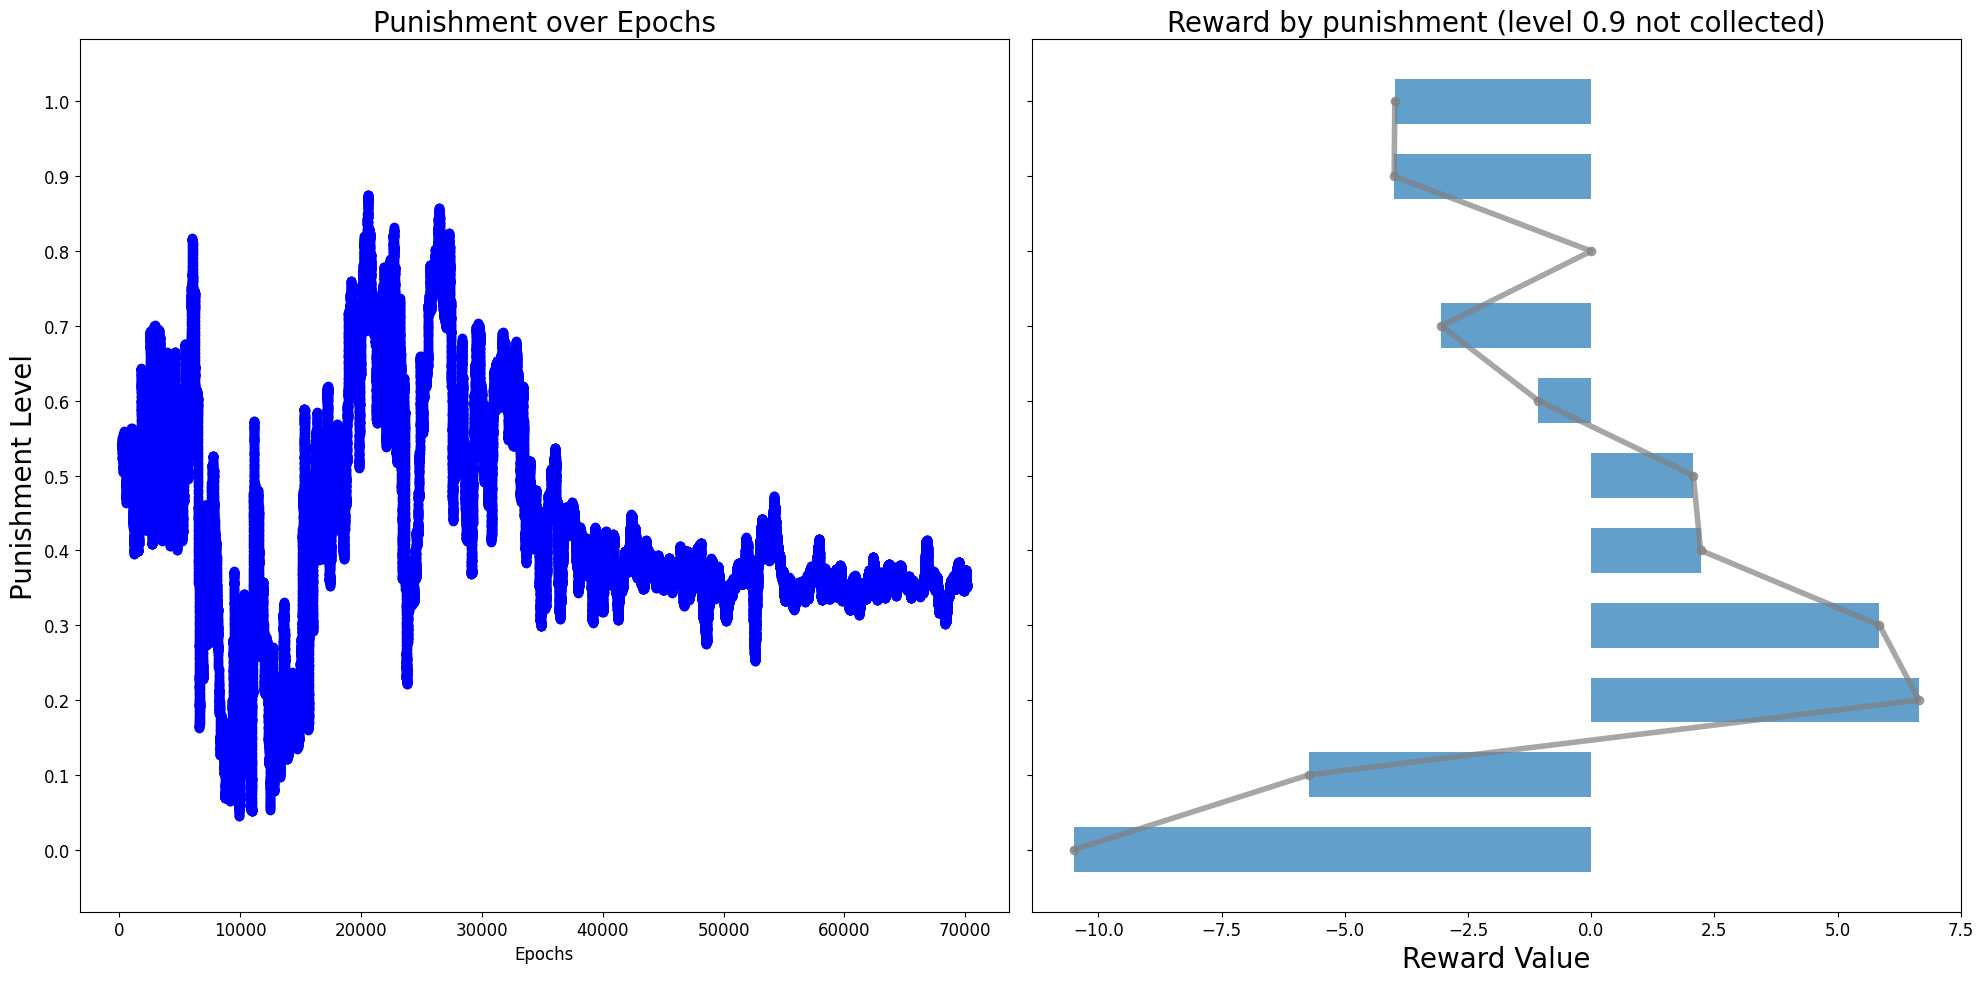

In [49]:
# plot 2 subplots: on the left, the average punishment over time, with x axis as time, y axis as average punishment; one the right, sharing the same y axis, with x axis being reward values (barh)

import matplotlib.pyplot as plt

folders = os.listdir('res')

# Example data
punishment_levels = pd.read_csv('res/collective_harm_state_punishment_respawn_0.005_vision_4_map_10_composite_views_False_multi_env_True__2agents_20250923-143956/Global_average_punishment_level_data.csv')['Value']
punishment_levels = punishment_levels.rolling(window=200).mean()
epochs = list(range(len(punishment_levels)))
rewards = []
for i in range(11):
    i *= 0.1
    i = round(i, 1)
    has_f = False
    for idx, f in enumerate(folders):
        if f'punish{i}' in f:
            reward = pd.read_csv(f'res/{f}/Mean_mean_individual_score_data.csv')['Value'][-1000:].mean()
            rewards.append(reward)
            has_f = True
    if not has_f:
        rewards.append(0)
    
    

# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

# Left subplot: line plot (Epochs vs Punishment)
ax1.plot(epochs, punishment_levels, marker='o', color="blue")
ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(ticks)
ax1.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Punishment Level", fontsize=20)
ax1.set_title("Punishment over Epochs", fontsize=20)

# Right subplot: bar plot (Reward vs Punishment)
ax2.barh(ticks, rewards, alpha=0.7, height=0.06)
ax2.plot(rewards, ticks, alpha=0.7, linewidth=4, marker='o', color="grey")
ax2.set_xlabel("Reward Value", fontsize=20)
ax2.set_title("Reward by punishment (level 0.9 not collected)", fontsize=20)

# Adjust layout
plt.tight_layout()
plt.show()

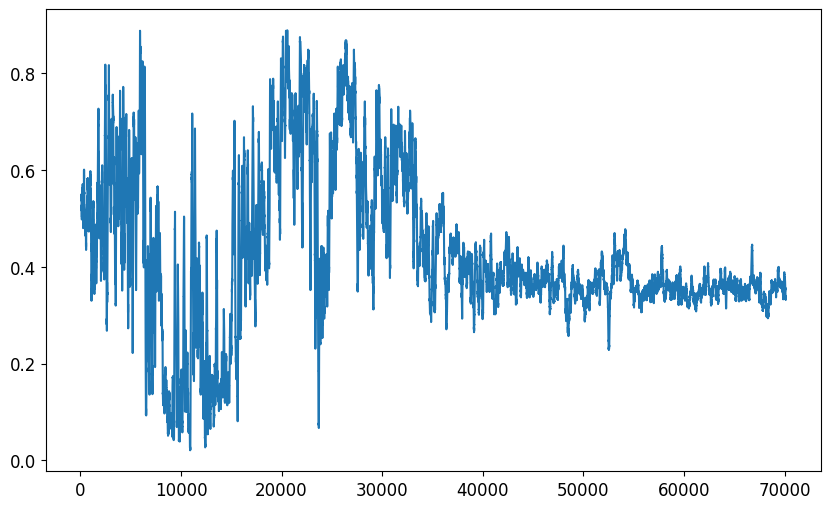

In [15]:
import matplotlib.pyplot as plt

punishment_levels = pd.read_csv('res/collective_harm_state_punishment_respawn_0.005_vision_4_map_10_composite_views_False_multi_env_True__2agents_20250923-143956/Global_average_punishment_level_data.csv')['Value']
plt.plot(punishment_levels.rolling(window=100).mean())